**This file is used to create the training set by some preprocessing like in [Ho 2017, sec 2.1](http://iopscience.iop.org/article/10.3847/1538-4357/836/1/5/meta).** 

In this version, inverse variance weight is removed. Furthermore, some simple tests were performed on the data set.

In [1]:
import os
import numpy as np
import time
from scipy import interpolate

In [2]:
import matplotlib.pyplot as plt
params = {
    'axes.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'text.usetex': False,
    #'figure.figsize': [4.5, 4.5],
    'figure.figsize': [6,6],
    #----------
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'image.cmap': 'jet',
    'legend.frameon':  False,
    'xtick.top': True,
    'ytick.right': True,
    #----------
    'lines.linewidth': 2.0,
#    'axes.labelsize': 12,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.minor.top': True, 
    'xtick.minor.bottom': True, 
    'ytick.minor.left': True, 
    'ytick.minor.right': True,
   }
plt.rcParams.update(params)

## load data

In [3]:
data = np.load('/nfs/P100/DSC/data/bstars_info.npy')
print data.shape, (data['label']==1).sum()
print data.dtype

(65808,) 3578
[('obsid', '<i8'), ('label', '<i8'), ('snru', '<f8'), ('snrg', '<f8'), ('snrr', '<f8'), ('snri', '<f8'), ('snrz', '<f8'), ('teff', '<f8'), ('teff_err', '<f8'), ('logg', '<f8'), ('logg_err', '<f8'), ('feh', '<f8'), ('feh_err', '<f8'), ('rv', '<f8'), ('rv_err', '<f8'), ('flux', '<f4', (4000,)), ('snr', '<f4', (4000,)), ('inver', '<f4', (4000,)), ('wavelen', '<f4', (4000,)), ('wavelen_ori', '<f4', (4000,)), ('snr_mask_1', '<f4', (4000,)), ('snr_mask_2', '<f4', (4000,))]


In [4]:
flux = data['flux'].astype(np.float64)
wavelen = data['wavelen'].astype(np.float64)
mask_bool = data['snr_mask_2']!=0

## linear interpolate

In [5]:
w_start = 4000.
w_end = 8800.
w_len = int(w_end)-int(w_start)+1
wavenew = np.linspace(w_start, w_end, w_len/1)

In [6]:
def interpolate_flux(wavelen, flux, wavenew):
    f_linear = interpolate.interp1d(wavelen, flux)
    return f_linear(wavenew)

If set the threshold of masked region as 15, 2.5% spectrum will be removed.

In [7]:
w_th = 15.
sel_arr = np.zeros([flux.shape[0]],dtype=np.bool)
fluxnew = np.zeros([flux.shape[0], int(w_len)],dtype=np.float32)
skip_count = 0
IsShow = False
for i in xrange(len(data)):
    mask_i = mask_bool[i]
    flux_i = flux[i][mask_i]
    wave_i = wavelen[i][mask_i]
    ind = np.where((wave_i>w_start)*(wave_i<w_end))[0][[0,-1]]
    if ind[0] == 0 or ind[1] == len(wave_i)-1:
        # remove those spectrum that wavelength range not enough.
        skip_count += 1
        continue
    wave_i = wave_i[ind[0]-1: ind[1]+2]
    flux_i = flux_i[ind[0]-1: ind[1]+2]
    delta  = np.max(wave_i[1:]-wave_i[:-1])
    if delta > w_th:
        # remove those spectrum that masked region greater than 'w_th'.
        skip_count += 1
        if IsShow:
            print "{0}:\t{1}\t{2}\t{3}\t{4}".format(i, ind, wave_i.min(),wave_i.max(),delta)
            # 24
            #fl = interpolate_flux(wave_i, flux_i, wavenew)
            #plt.plot(wavenew, fl, 'r.')
            plt.plot(wave_i, flux_i, '.')
            plt.plot(wave_i, wave_i, 'k.',ms=0.3)
            plt.plot(wave_i[:-1],(wave_i[1:]-wave_i[:-1])*50, '-')
            plt.hlines(w_th*50, wavenew[0],wavenew[-1],'red')
            #plt.xlim([5000,7000])
            plt.show()
            #break
            if skip_count > 10:
                break
        continue
    fl = interpolate_flux(wave_i, flux_i, wavenew)
    sel_arr[i] = True
    fluxnew[i,:] = fl[:]
print skip_count, skip_count/float(i)   

1698 0.0258027261538


**check interpolation**

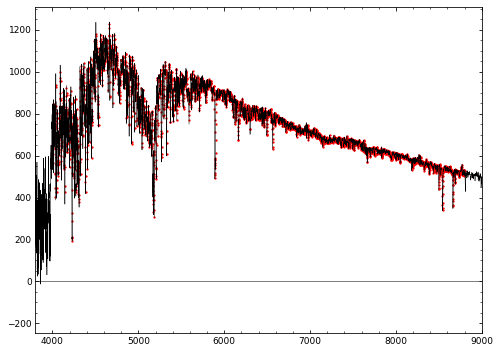

In [8]:
num = 200
fig, axis = plt.subplots(figsize=(8,6))
axis.plot(wavenew,fluxnew[num], 'r.', label='interpolate', ms=2.5)
axis.plot(wavelen[num], flux[num], 'k-', label='origin', lw=0.5)
axis.set_xlim([3800,9000])
plt.show()

## Gaussian smoothing with $\sigma=35nm$

In [9]:
sigma = 350
ones = np.ones_like(wavenew,dtype=np.float64)
dis = np.arange(sigma*3+1,dtype=np.float64)
dis -= dis[-1]/2.
kernel = np.exp(-0.5*(dis/sigma)**2.)
w_conv = np.convolve(ones, kernel, mode='same')

In [10]:
flux_s = np.zeros([flux.shape[0], w_len],dtype=np.float32)
for i in xrange(len(flux_s)):
    if sel_arr[i]:
        flux_s[i,:] = np.convolve(fluxnew[i], kernel, mode='same')/w_conv

In [11]:
flux_norm = np.zeros_like(flux_s)
flux_norm[sel_arr] = fluxnew[sel_arr] / flux_s[sel_arr]

**check smoothing**

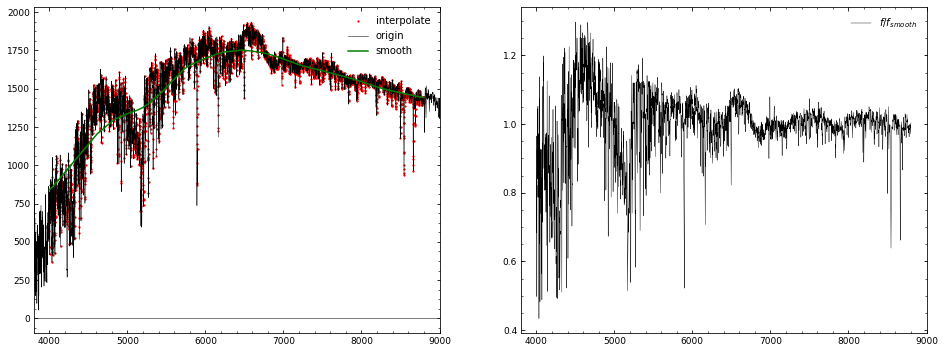

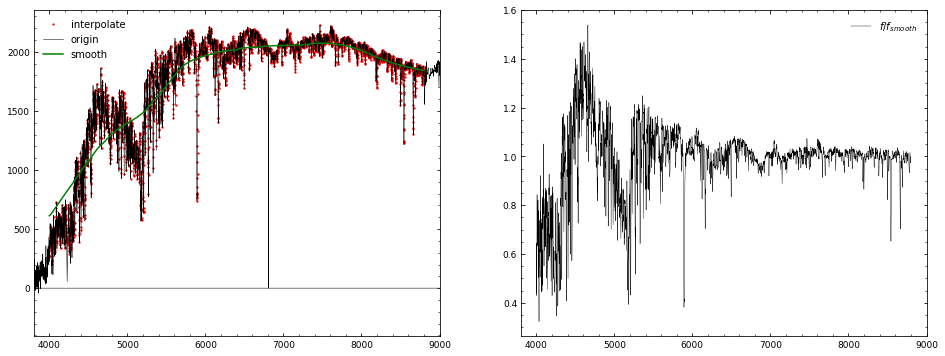

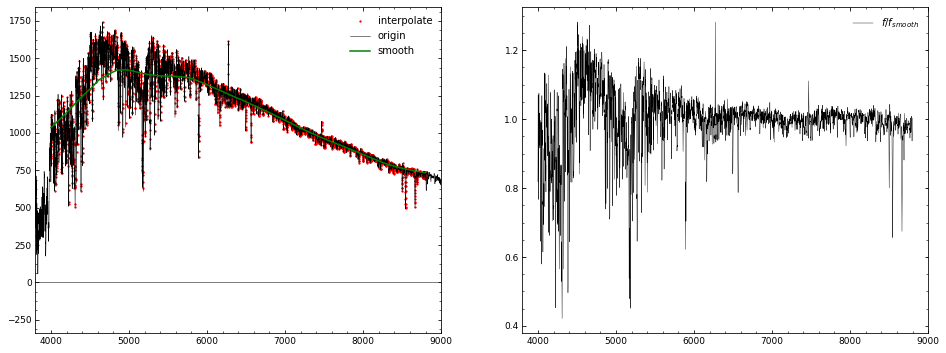

In [12]:
for num in [48, 11233, 4353]:
    fig, axes = plt.subplots(1,2,figsize=(16,6))
    axes[0].plot(wavenew,fluxnew[num], 'r.', label='interpolate', ms=2.5)
    axes[0].plot(wavelen[num], flux[num], 'k-', label='origin', lw=0.5)
    axes[0].plot(wavenew,flux_s[num], 'g-', label='smooth', lw=1.5)
    axes[0].set_xlim([3800,9000])
    axes[0].legend()
    axes[1].plot(wavenew, flux_norm[num], 'k-', label='$f/f_{smooth}$', lw=0.4)
    axes[1].set_xlim([3800,9000])
    axes[1].legend()
    plt.show()

**save data**

In [13]:
dt = np.dtype([('obsid', np.int32, 1), ('label', np.int32, 1), ('flux_norm', np.float32, len(wavenew))])
data_new = np.empty([sel_arr.sum()], dtype=dt)

In [14]:
data.dtype

dtype([('obsid', '<i8'), ('label', '<i8'), ('snru', '<f8'), ('snrg', '<f8'), ('snrr', '<f8'), ('snri', '<f8'), ('snrz', '<f8'), ('teff', '<f8'), ('teff_err', '<f8'), ('logg', '<f8'), ('logg_err', '<f8'), ('feh', '<f8'), ('feh_err', '<f8'), ('rv', '<f8'), ('rv_err', '<f8'), ('flux', '<f4', (4000,)), ('snr', '<f4', (4000,)), ('inver', '<f4', (4000,)), ('wavelen', '<f4', (4000,)), ('wavelen_ori', '<f4', (4000,)), ('snr_mask_1', '<f4', (4000,)), ('snr_mask_2', '<f4', (4000,))])

In [15]:
data_new['obsid'] = data['obsid'][sel_arr]
data_new['label'] = data['label'][sel_arr]
data_new['flux_norm'] = flux_norm[sel_arr]

In [16]:
np.save('/nfs/P100/DSC/data/1218/bstars_fluxnorm.npy', data_new)

## Create training, validation and test set, TFrecords format.

Seperate dataset for training, validation and test with fraction 0.8,0.1,0.1

In [17]:
import numpy as np
import os
dirbase = '/nfs/P100/DSC/data/1218'
data_new = np.load(os.path.join(dirbase,'bstars_fluxnorm.npy'))

In [18]:
frac = np.array([0.8,0.9,1.0])
size = data_new.shape[0]
print size

64110


In [19]:
random_ind = np.random.permutation(np.arange(size))
ind_dataset = np.ceil(frac*size).astype(np.int32)
train_dataset = data_new[random_ind[:ind_dataset[0]]]
valid_dataset = data_new[random_ind[ind_dataset[0]:ind_dataset[1]]]
test_dataset = data_new[random_ind[ind_dataset[1]:ind_dataset[2]]]

In [20]:
train_norm_mean = train_dataset['flux_norm'].mean(axis=0)
train_norm_std = train_dataset['flux_norm'].std(axis=0)
np.save(os.path.join(dirbase,'train_mean_std.npy'), np.c_[train_norm_mean, train_norm_std])

Pixel-wise normalization of dataset by the mean and std of training set. When testing result, the dataset also should be normalized by this array: "train_mean_std.npy"

In [21]:
train_dataset['flux_norm'] = (train_dataset['flux_norm'] - train_norm_mean) / train_norm_std
valid_dataset['flux_norm'] = (valid_dataset['flux_norm'] - train_norm_mean) / train_norm_std

- test normalized flux spectrum

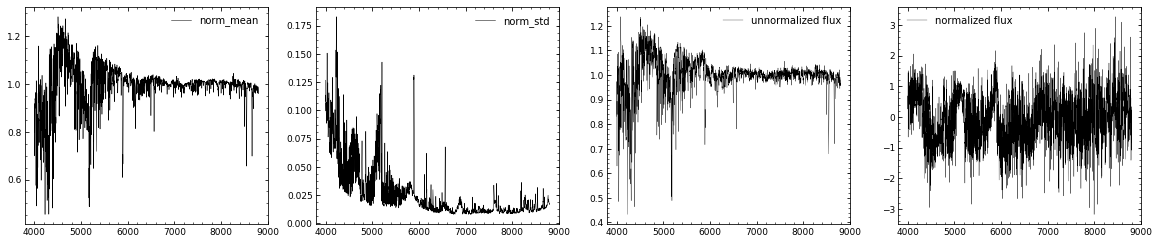

In [22]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
axes[0].plot(wavenew,train_norm_mean, 'k-', label='norm_mean', lw=0.5)
axes[1].plot(wavenew,train_norm_std, 'k-', label='norm_std', lw=0.5)
axes[2].plot(wavenew,train_dataset['flux_norm'][90]*train_norm_std+train_norm_mean, 'k-', label='unnormalized flux', lw=0.3)
axes[3].plot(wavenew,train_dataset['flux_norm'][90], 'k-', label='normalized flux', lw=0.3)
for i in xrange(4):
    axes[i].set_xlim([3800,9000])
    axes[i].legend()
plt.show()

In [23]:
print size == np.unique(random_ind).shape[0]
print train_dataset.shape[0]/float(size)
print valid_dataset.shape[0]/float(size)
print test_dataset.shape[0]/float(size)
print train_dataset['label'][:40]
print valid_dataset['label'][:40]
print test_dataset['label'][:40]
print np.unique(np.hstack([train_dataset['obsid'], valid_dataset['obsid'], test_dataset['obsid']])).shape[0] == size

True
0.8
0.1
0.1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0]
True


### oversampling for training and validation sets:

In [24]:
def oversampling(sample):
    index = np.arange(sample.shape[0])
    dstar_ind = index[sample['label']==1]
    sstar_ind = index[sample['label']==0]
    resample_ind = dstar_ind[np.random.randint(0, dstar_ind.shape[0]-1, sstar_ind.shape[0])]
    ind_new = np.hstack([sstar_ind,resample_ind])
    ind_new = ind_new[np.random.permutation(np.arange(ind_new.shape[0]))]
    return ind_new

In [25]:
reind = oversampling(train_dataset)
train_dataset = train_dataset[reind]
reind = oversampling(valid_dataset)
valid_dataset = valid_dataset[reind]

In [26]:
np.save(os.path.join(dirbase,'training.npy'), train_dataset)
np.save(os.path.join(dirbase,'test.npy'), test_dataset)
np.save(os.path.join(dirbase,'valid.npy'), valid_dataset)

---
## create TFrecord file:

In [27]:
import os
import numpy as np
import tensorflow as tf

/home/mtx/local/anaconda2/envs/tf1.5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Define corresponding data type.

In [28]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

Rewrite the following functions for different dataset.

In [29]:
def convert_to(data_set, Dir, name):
    """Converts a dataset to tfrecords."""
    features = data_set.features
    labels = data_set.labels
    num_examples = data_set.num_examples

    if features.shape[0] != num_examples:
        raise ValueError('Features size %d does not match label size %d.' %
                         (features.shape[0], num_examples))

    filename = os.path.join(Dir, name + '.tfrecords')
    print('Writing', filename)
    writer = tf.python_io.TFRecordWriter(filename)
    for index in xrange(num_examples):
        data_set.index = index
        feature_raw = features[index].reshape(-1).tolist()
        label_raw = labels[index].reshape(-1).tolist()
        example = tf.train.Example(features=tf.train.Features(feature={
            'index': _int64_feature(data_set.index),
            'label_raw': _float_feature(label_raw),
            'feature_raw': _float_feature(feature_raw)}))
        writer.write(example.SerializeToString())
    writer.close()

In [30]:
def main(data, filename):
    # Get the data.
    class data_set():
        pass
    Len = data.shape[0]
    features = data['flux_norm']
    labels = data['label'].reshape(-1,1)
  
    data_set.features = features
    data_set.labels = labels
    data_set.num_examples = Len

    convert_to(data_set, Dir=dirbase, name=filename)

Run the convert code.

In [31]:
main(train_dataset,'training')
main(valid_dataset,'valid')
main(test_dataset,'test')

('Writing', '/nfs/P100/DSC/data/1218/training.tfrecords')
('Writing', '/nfs/P100/DSC/data/1218/valid.tfrecords')
('Writing', '/nfs/P100/DSC/data/1218/test.tfrecords')
